A notebook to compare the Froude number between 2d and 3D runs. 

In [55]:
import matplotlib.pyplot as plt
import netCDF4 as nc
import datetime
import os
import numpy as np

import froude
from salishsea_tools.nowcast import analyze
%matplotlib inline

#Load data

In [2]:
def load_simulation(path, period, d1, d2, n2=True):
  
    for grid in ['grid_T', 'grid_U', 'grid_W', 'grid_V']:
        filename = 'SalishSea_{}_{}_{}_{}.nc'.format(period,d1.strftime('%Y%m%d'), d2.strftime('%Y%m%d'),grid)
        print os.path.join(path,filename)
        d = nc.Dataset(os.path.join(path,filename))
        if grid=='grid_T':
            sal = d.variables['vosaline'][:]
            sal = np.ma.masked_values(sal,0)
            depsT = d.variables['deptht'][:]
            temp = d.variables['votemper'][:]
            temp = np.ma.masked_values(temp,0)
            ssh = d.variables['sossheig'][:]
            if n2:
                n2 = d.variables['buoy_n2'][:]
                n2 = np.ma.masked_values(n2,0)
            else: 
                n2=np.zeros(temp.shape)
            times = d.variables['time_counter'][:]
            try :
                time_origin = datetime.datetime.strptime(d.variables['time_counter'].time_origin, 
                                                    '%Y-%m-%d %H:%M:%S')
            except :
                time_origin = datetime.datetime.strptime(d.variables['time_counter'].time_origin, 
                                                    ' %Y-%b-%d %H:%M:%S')

        if grid =='grid_U':
            U = d.variables['vozocrtx'][:]
            U = np.ma.masked_values(U,0)
            depsU=d.variables['depthu'][:]

        if grid=='grid_W':
            try:
                avt = d.variables['vert_eddy_diff'][:]
                avm = d.variables['vert_eddy_visc'][:]
            except KeyError:
                avt = d.variables['ve_eddy_diff'][:]
                avm = d.variables['ve_eddy_visc'][:]
            avm = np.ma.masked_values(avm,0)
            avt = np.ma.masked_values(avt,0)
            depsW=d.variables['depthw'][:]

        if grid=='grid_V':
            V = d.variables['vomecrty'][:]
            V= np.ma.masked_values(V,0)
            depsV=d.variables['depthv'][:]

    
    return sal, temp, ssh, n2, depsT, U, depsU, avt,avm, depsW, V, depsV, times, time_origin

In [3]:
paths = {'2D': '/data/nsoontie/MEOPAR/SalishSea/results/2Ddomain/3.6/base_aug/',
         '3D': '/data/nsoontie/MEOPAR/SalishSea/results/stratification/dwr_diff1e-6_visc1e-5/'}
period = '1d'
d1 = datetime.datetime(2003,8,19)
d2 = datetime.datetime(2003,9,27)

n2_flag = {'2D': True,
           '3D': False}

In [4]:
sals={}; temps={}; sshs={};n2s={}; depsTs={}; Us={}; depsUs={} 
avts={}; avms={}; depsWs={}; Vs={}; depsVs={}; times={}; time_origins={};

for key in paths:
    (sals[key], temps[key], sshs[key], n2s[key], depsTs[key], 
    Us[key], depsUs[key], avts[key],avms[key], depsWs[key], Vs[key], depsVs[key], times[key], 
    time_origins[key])= load_simulation(paths[key],period,d1,d2,n2_flag[key])

/data/nsoontie/MEOPAR/SalishSea/results/2Ddomain/3.6/base_aug/SalishSea_1d_20030819_20030927_grid_T.nc
/data/nsoontie/MEOPAR/SalishSea/results/2Ddomain/3.6/base_aug/SalishSea_1d_20030819_20030927_grid_U.nc
/data/nsoontie/MEOPAR/SalishSea/results/2Ddomain/3.6/base_aug/SalishSea_1d_20030819_20030927_grid_W.nc
/data/nsoontie/MEOPAR/SalishSea/results/2Ddomain/3.6/base_aug/SalishSea_1d_20030819_20030927_grid_V.nc
/data/nsoontie/MEOPAR/SalishSea/results/stratification/dwr_diff1e-6_visc1e-5/SalishSea_1d_20030819_20030927_grid_T.nc
/data/nsoontie/MEOPAR/SalishSea/results/stratification/dwr_diff1e-6_visc1e-5/SalishSea_1d_20030819_20030927_grid_U.nc
/data/nsoontie/MEOPAR/SalishSea/results/stratification/dwr_diff1e-6_visc1e-5/SalishSea_1d_20030819_20030927_grid_W.nc
/data/nsoontie/MEOPAR/SalishSea/results/stratification/dwr_diff1e-6_visc1e-5/SalishSea_1d_20030819_20030927_grid_V.nc


#Slice 2D data

In [37]:
yslice=5
key='2D'
n2s[key] = n2s[key][:,:,yslice,:]
temps[key] = temps[key][:,:,yslice,:]
sals[key] = sals[key][:,:,yslice,:]
Us[key] = Us[key][:,:,yslice,:]
Vs[key] = Vs[key][:,:,yslice,:]
avts[key] = avts[key][:,:,yslice,:]
avms[key] = avms[key][:,:,yslice,:]

#Isolate Thalweg in 3D


In [11]:
lines = np.loadtxt('/data/nsoontie/MEOPAR/tools/bathymetry/thalweg_working.txt', delimiter=" ")
lines = lines.astype(int)
key='3D'
sals[key] = sals[key][:,:,lines[:,0], lines[:,1]]
temps[key] = temps[key][:,:,lines[:,0], lines[:,1]]
avts[key] = avts[key][:,:,lines[:,0], lines[:,1]]
avms[key] = avms[key][:,:,lines[:,0], lines[:,1]]

In [12]:
Us[key] = 0.5*(Us[key][:,:,lines[:,0], lines[:,1]] + Us[key][:,:,lines[:,0], lines[:,1]-1])
Vs[key] = 0.5*(Vs[key][:,:,lines[:,0], lines[:,1]] + Vs[key][:,:,lines[:,0]-1, lines[:,1]])

## 3D buoyancy frequency

In [27]:
mesh = nc.Dataset('/ocean/nsoontie/MEOPAR/Ariane/mesh_mask.nc')
e3w = mesh.variables['e3w'][:]
e3w = e3w[0, :, lines[:,0], lines[:,1]]


n2s[key] = froude.calculate_buoyancy_frequency(temps[key], sals[key], e3w.T, depth_axis=1)

Quick plot of 3D to see if I can average over same region.

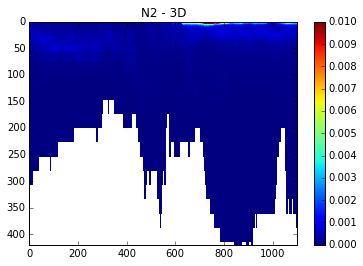

In [53]:
key='3D'
nmin=0; nmax=0.01;
t=39
plt.pcolormesh(np.arange(n2s[key].shape[-1]), depsTs[key], n2s[key][t,:,:],vmin=nmin,vmax=nmax)
plt.colorbar()
plt.axis([0,1100,420,0])
plt.title('N2 - {}'.format(key))

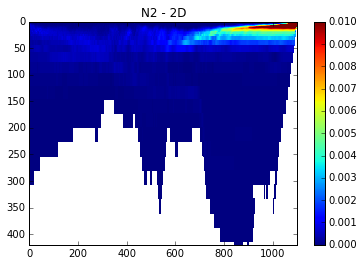

In [54]:
key='2D'
t=39
plt.pcolormesh(np.arange(n2s[key].shape[-1]), depsTs[key], n2s[key][t,:,:], vmin=nmin,vmax=nmax)
plt.colorbar()
plt.axis([0,1100,420,0])
plt.title('N2 - {}'.format(key))

2D case more strongly stratified, hence less mixing.

#Froude numbers

In [39]:

Frs={}; cs={}; uavgs = {}; dates={};rhos = {}
for key in paths:
    rhos[key] = froude.calculate_density(temps[key], sals[key])
    Frs[key], cs[key], uavgs[key], dates[key] = froude.froude_time_series(
                                                    n2s[key], rhos[key], Us[key], depsTs[key], depsUs[key],
                                                    times[key], time_origins[key])

In [56]:
xmin=300
xmax=700

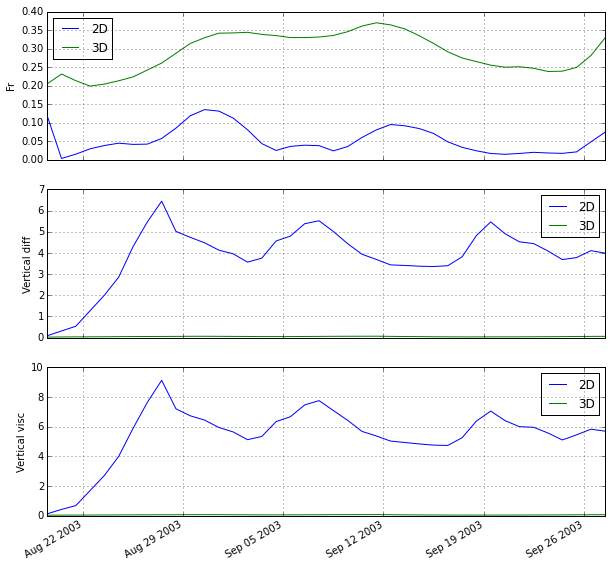

In [66]:
fig, axs = plt.subplots(3,1,sharex=True, figsize=(10,10))
for key in paths:
    ax=axs[0]
    ax.plot(dates[key],Frs[key], label=key)
    ax=axs[1]
    avts_dep_avg =  np.ma.mean(analyze.depth_average(avts[key][:,1:,xmin:xmax+1],depsWs[key][1:],1),axis=1)
    ax.plot(dates[key],avts_dep_avg,label=key)
    ax=axs[2]
    avms_dep_avg =  np.ma.mean(analyze.depth_average(avms[key][:,1:,xmin:xmax+1],depsWs[key][1:],1),axis=1)
    ax.plot(dates[key],avms_dep_avg,label=key)
 
ax=axs[0]
ax.legend(loc=0)
ax.grid()
ax.set_ylabel('Fr')

ax=axs[1]
ax.legend(loc=0)
ax.grid()
ax.set_ylabel('Vertical diff')

ax=axs[2]
ax.legend(loc=0)
ax.grid()
ax.set_ylabel('Vertical visc')
fig.autofmt_xdate()

Froude number suggests more mixing in 3D but the vertical eddy coefficients are much smaller (an order of magnitude). Is this an artifact of 3.6 vs 3.4? 

* 3.6 used backgound visc/diff 1e-4 and 1e-6
* 3.4 used background visc/diff 1e-5 and 1e-6
* Both use the k-eps. 

#Diffusivities

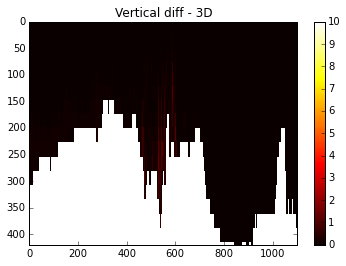

In [76]:
key='3D'
dmin=0; dmax=10;
t=39
plt.pcolormesh(np.arange(avts[key].shape[-1]), depsTs[key], avts[key][t,:,:],vmin=dmin,vmax=dmax,cmap='hot')
plt.colorbar()
plt.axis([0,1100,420,0])
plt.title('Vertical diff - {}'.format(key))

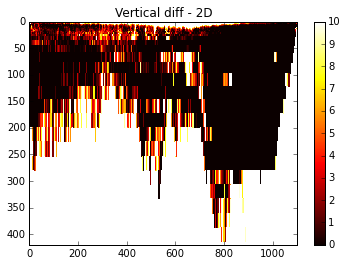

In [77]:
key='2D'
t=39
plt.pcolormesh(np.arange(avts[key].shape[-1]), depsTs[key], avts[key][t,:,:],vmin=dmin,vmax=dmax,cmap='hot')
plt.colorbar()
plt.axis([0,1100,420,0])
plt.title('Vertical diff - {}'.format(key))